In [19]:
%cd /home/dsharonov/projects/kursach/timeseries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import  DataLoader
from sklearn.preprocessing import MinMaxScaler
import random
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from src.models.dataset import TimeSeriesWithNewsDataset, custom_collate_fn
from src.models.newsformer import Newsformer, train, test
import warnings
from tqdm import tqdm
from src.parsers import fetch_moex_data
warnings.filterwarnings("ignore")

/home/dsharonov/projects/kursach/timeseries


In [20]:
security = 'GAZP'
years = [
        # 2018, 2019,2020,2021,
        2022 ,2023, 2024
        ]
all_data = pd.DataFrame()

for year in years:
    from_date = f'{year}-01-01'
    till_date = f'{year}-12-31'
    print(f"Получение данных за {year} год...")
    data = fetch_moex_data(security, from_date, till_date)
    all_data = pd.concat([all_data, data], ignore_index=True)

if not all_data.empty:
    all_data.to_csv('/home/dsharonov/projects/kursach/timeseries/data/price_data/news_gazprom_historical_data.csv', index=False)
    print("Данные успешно сохранены в 'gazprom_historical_data.csv'")
else:
    print("Не удалось получить данные.")

Получение данных за 2022 год...
Получение данных за 2023 год...
Получение данных за 2024 год...
Данные успешно сохранены в 'gazprom_historical_data.csv'


In [5]:
news_df = pd.read_csv('/home/dsharonov/projects/kursach/timeseries/data/text_data_clean/news_data.csv', parse_dates=['date'])
news_df = news_df.sort_values('date')
news_df = news_df.dropna(subset=['full_text'])

tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
bert_model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased')
bert_model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
bert_model.to(device)
def get_text_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128, padding='max_length')
    inputs = {k: v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # Возьмём эмбеддинг CLS-токена
    cls_embedding = outputs.last_hidden_state[:,0,:].squeeze(0) # [768]
    return cls_embedding.cpu().numpy()


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
date_embeddings = {}
unique_dates = news_df['date'].unique()

# Поскольку по условию в датасете только одна новость на дату,
# мы не усредняем, а сразу берём эмбеддинг единственной новости.
for d in tqdm(unique_dates, desc='Processing News Embeddings'):
    day_text = news_df[news_df['date'] == d]['full_text'].iloc[0]
    emb = get_text_embedding(day_text)
    date_embeddings[d] = emb

Processing News Embeddings: 100%|██████████| 1025/1025 [00:03<00:00, 266.38it/s]


In [8]:
news_emb_df = pd.DataFrame(list(date_embeddings.items()), columns=['DATE', 'EMB'])
news_emb_df = news_emb_df.sort_values('DATE').reset_index(drop=True)

In [22]:
data = pd.read_csv('/home/dsharonov/projects/kursach/timeseries/data/price_data/news_gazprom_historical_data.csv', parse_dates=['TRADEDATE'])
data = data[data['BOARDID'] == 'TQBR']
data = data.sort_values('TRADEDATE').reset_index(drop=True)

# Соединяем эмбеддинги с данными о ценах (по дате)
merged = pd.merge(data, news_emb_df, left_on='TRADEDATE', right_on='DATE', how='left')
merged = merged.drop(columns=['DATE'])

# Если на какую-то дату нет новости, заполним нулями
merged['EMB'] = merged['EMB'].apply(lambda x: np.zeros((768,)) if isinstance(x, float) else x)

prices = merged['LEGALCLOSEPRICE'].values.reshape(-1, 1)
dates = merged['TRADEDATE'].values
news_embeddings = np.stack(merged['EMB'].values, axis=0)  # shape: (N, 768)

# Масштабируем цены
scaler = MinMaxScaler(feature_range=(0,1))
scaled_prices = scaler.fit_transform(prices)

# Формируем полные признаки: цены + эмбеддинги
full_features = np.hstack([scaled_prices, news_embeddings])  # shape: (N, 1+768)

# Делим на обучающую и валидационную выборки
train_size = int(len(full_features) * 0.7)
train_data = full_features[:train_size]
train_dates = dates[:train_size]

val_data = full_features[train_size:]
val_dates = dates[train_size:]

In [23]:
seq_length = 60
label_length = 30
pred_length = 10

train_dataset = TimeSeriesWithNewsDataset(train_data, train_dates, seq_length, label_length, pred_length)
val_dataset = TimeSeriesWithNewsDataset(val_data, val_dates, seq_length, label_length, pred_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)


In [24]:
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = Newsformer(
    enc_in=769,  # 1 признак цены + 768 эмбеддингов новостей
    dec_in=769,
    c_out=1,
    seq_len=seq_length,
    label_len=label_length,
    out_len=pred_length,
    d_model=512,
    n_heads=4,
    e_layers=4,
    d_layers=2,
    d_ff=2048,
    dropout=0.2
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=8, gamma=0.5)

In [25]:
num_epochs = 60
save_path = '/home/dsharonov/projects/kursach/timeseries/data/weights/newsformer_best_weight.pth'
train(num_epochs, 
      model, 
      criterion, 
      optimizer, 
      scheduler, 
      train_loader, 
      val_loader, 
      label_length, 
      pred_length, 
      device=device,
      save_path=save_path)


--> New best model saved at epoch 1, Val Loss: 0.003876
Epoch [1/60] Train Loss: 1.878676, Val Loss: 0.003876
Epoch [2/60] Train Loss: 0.199215, Val Loss: 0.185533
Epoch [3/60] Train Loss: 0.059878, Val Loss: 0.169113
Epoch [4/60] Train Loss: 0.047557, Val Loss: 0.084819
Epoch [5/60] Train Loss: 0.038443, Val Loss: 0.051348
Epoch [6/60] Train Loss: 0.037311, Val Loss: 0.045658
Epoch [7/60] Train Loss: 0.036110, Val Loss: 0.070882
Epoch [8/60] Train Loss: 0.036208, Val Loss: 0.056061
Epoch [9/60] Train Loss: 0.036446, Val Loss: 0.038313
Epoch [10/60] Train Loss: 0.034812, Val Loss: 0.043864
Epoch [11/60] Train Loss: 0.035629, Val Loss: 0.060220
Epoch [12/60] Train Loss: 0.033349, Val Loss: 0.062218
Epoch [13/60] Train Loss: 0.033316, Val Loss: 0.054739
Epoch [14/60] Train Loss: 0.032435, Val Loss: 0.062222
Epoch [15/60] Train Loss: 0.032768, Val Loss: 0.048173
Epoch [16/60] Train Loss: 0.032220, Val Loss: 0.057868
Epoch [17/60] Train Loss: 0.031099, Val Loss: 0.050727
Epoch [18/60] Trai

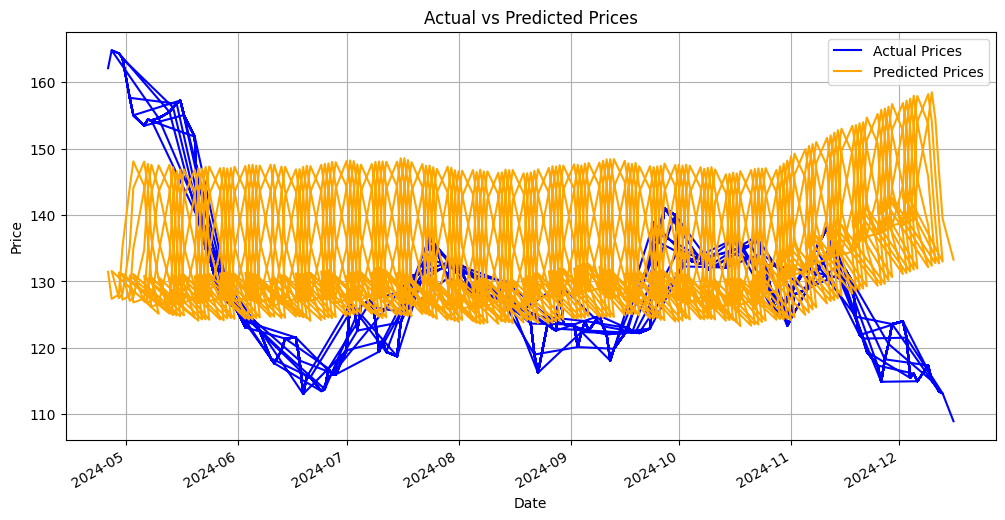

Test Metrics:
MAE: 12.323206901550293
MSE: 234.74380493164062
MAPE: 0.09720415621995926
RMSE: 15.321351051330566


In [26]:
# Предполагается, что переменная save_path определена и содержит путь к сохранённой модели
checkpoint = torch.load(save_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Тестирование модели
mae, mse, mape, rmse = test(model, val_loader, scaler, device, label_length, pred_length)
print(f'Test Metrics:\nMAE: {mae}\nMSE: {mse}\nMAPE: {mape}\nRMSE: {rmse}')